# Ok, so I have clusters... Now what?

## Clusters are about providing options and insight

> "You know you've done clustering right when your clusters make sense and are meaningful" - Maggie Giust

> "The difference between a goat rodeo and making clusters is _using your clusters for deeper insight_." - RO

## So what are our options?
- Step 1 is explore each cluster to compare and contrast the data in each.
- Step 2 is to name your clusters if they make sense, in English. "Manually" naming the clusters is powerful stuff and very common with customer segmentation, threat detection, and elsewhere in industry! Try to name them, if you can.


- Option 1: Use the clusters to simplify multiple other variables (dimensionality reduction)
- Option 2: Use cluster names as a target variable in order to classify incoming new data into the appropriate cluster.
- Option 3: Perform deeper EDA and modeling for each cluster (assuming we have a target variable, but its relationship is different on each cluster, or the interplay of other features is different on each feature)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [2]:
# Acquire
df = pd.read_csv('https://gist.githubusercontent.com/ryanorsinger/cc276eea59e8295204d1f581c8da509f/raw/2388559aef7a0700eb31e7604351364b16e99653/mall_customers.csv', index_col="customer_id")
df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## Thoughts on data preparation
- If if gender isn't a big impact on age, income, or spending score, we can drop that column.
- KMeans does well with continuous values and not a bunch of one hot encoded columns for categories.
- If the populations of each gender are significantly different, we could encode the gender column to boolean or 0/1 values. But BEWARE about clustering on a bunch of boolean (0/1) values, since the curse of dimensionality sets in rapidly with each new non-continuous feature.
- I am choosing to leave outliers in the dataset to catch extremes in income/spending/age. (revisit later)

In [3]:
# Looks like the central tendencies and 
df.groupby("gender").agg(["min", "mean", "median", "std", "max"])

age                                  annual_income                    \
       min       mean median        std max           min       mean median   
gender                                                                        
Female  18  38.098214     35  12.644095  68            16  59.250000   60.0   
Male    18  39.806818     37  15.514812  70            15  62.227273   62.5   

                       spending_score                                  
              std  max            min       mean median       std max  
gender                                                                 
Female  26.011952  126              5  51.526786     50  24.11495  99  
Male    26.638373  137              1  48.511364     50  27.89677  97

In [4]:
# Based on the above insight
# If we had time and wanted to be more certain, we could run t-tests for independence between gender and each numeric column
df = df.drop(columns="gender")

In [6]:
# For the sake of the low amount of observations, we'll work with the entire dataset
train = df
train.head()

,age,annual_income,spending_score
customer_id,,,
1,19,15,39
2,21,15,81
3,20,16,6
4,23,16,77
5,31,17,40


In [7]:
# Scale age, income, and spending score features
# make the thing
scaler = MinMaxScaler()

# fit the thing on train
scaler.fit(train)

# use the thing (scale train, validate, and test)
train_scaled = scaler.transform(train)

# If we had the validate and test sets
# validate_scaled = scaler.transform(validate) 
# test_scaled = scaler.transform(test) if we had validate

# turn the scaled arrays into dataframes
train_scaled = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)

# If we had the validate and test 
# validate_scaled = pd.DataFrame(train_scaled, columns=validate.columns) 
# test_scaled = pd.DataFrame(train_scaled, columns=test.columns)
train_scaled.head()

,age,annual_income,spending_score
customer_id,,,
1,0.019231,0.000000,0.387755
2,0.057692,0.000000,0.816327
3,0.038462,0.008197,0.051020
4,0.096154,0.008197,0.775510
5,0.250000,0.016393,0.397959


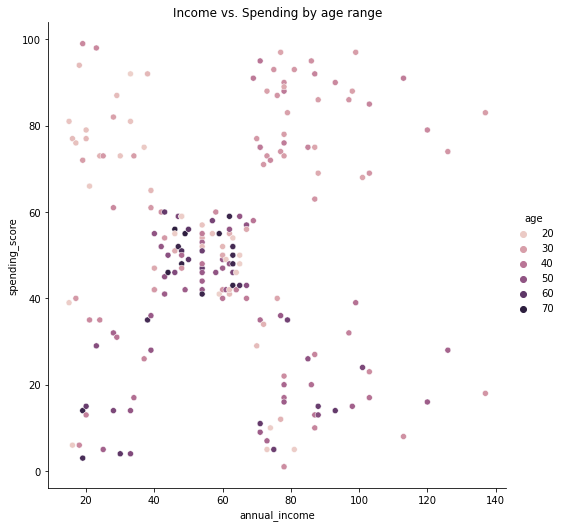

In [8]:
# We can plot a numeric x variable, a numeric y variable,
# Here, we'll look at income vs. spending score broken out by gender with a hue for ages
sns.relplot(data=train, x="annual_income", y="spending_score", hue='age', height=7, aspect=1).set(title="Income vs. Spending by age range")

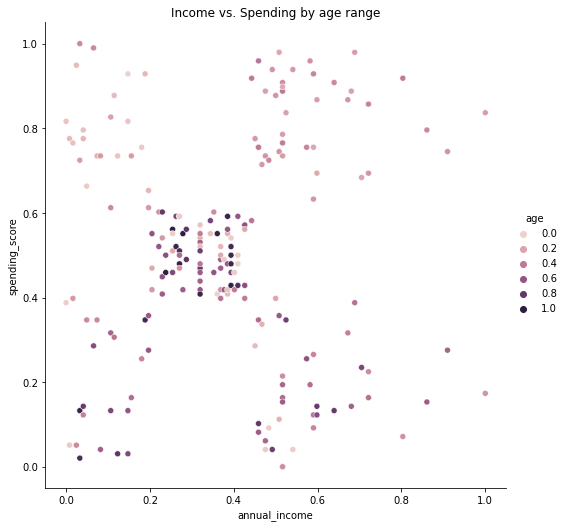

In [9]:
# Notice that using a linear scaler (like MinMax or StandardScaler) does not change the shape/relationships of the data
sns.relplot(data=train_scaled, x="annual_income", y="spending_score", hue='age', height=7, aspect=1).set(title="Income vs. Spending by age range")

### Takeaways from exploration:
- Visually, there appear to be 5 discernible groupings based on income and spending score.
- Some age similarities appear in some of those discernible groupings
- The "center" group appears to have mixed ages.
- But now let's visualize an elbow method to makes sure we're not seeing faces on Mars...

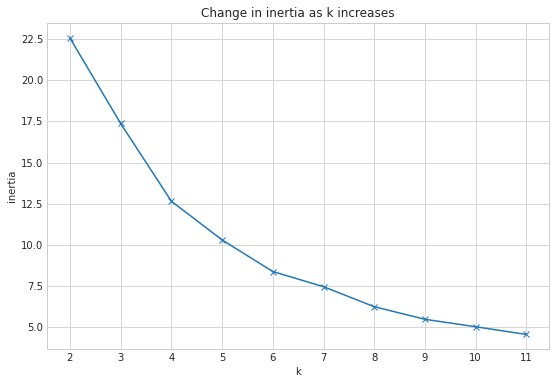

In [10]:
# Let's visualize an elbow method to see if inertia values support our visual hunch that there are 5 clear groups
# lets plot inertia vs k

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k, random_state=42).fit(train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [11]:
# Let's move forward with k=5
kmeans = KMeans(n_clusters = 5, random_state=42)
kmeans.fit(train_scaled)

# And assign the cluster number to a column on the dataframe
train_scaled["cluster"] = kmeans.predict(train_scaled)
train_scaled.head()

,age,annual_income,spending_score,cluster
customer_id,,,,
1,0.019231,0.000000,0.387755,2
2,0.057692,0.000000,0.816327,4
3,0.038462,0.008197,0.051020,2
4,0.096154,0.008197,0.775510,4
5,0.250000,0.016393,0.397959,2


In [12]:
train_scaled.cluster.value_counts()

0    58
2    49
1    40
3    30
4    23
Name: cluster, dtype: int64

## So we have clusters and 5 looks promising...

![caution road sign saying "now what?" to show confusion](now_what_roadsign.jpeg)

> "The difference between a goat rodeo and making clusters is _using your clusters for deeper insight_." - RO

## So what are our options?
- Step 1 is explore each cluster to compare and contrast the data in each. 
- Step 2 is to name your clusters if they make sense, in English. "Manually" naming the clusters is powerful stuff and very common with customer segmentation, threat detection, and elsewhere in industry! Try to name them, if you can.
- Option 1: Use the clusters to simplify multiple other variables (dimensionality reduction)
- Option 2: Use cluster names as a target variable in order to classify incoming new data into the appropriate cluster.
- Option 3: Perform deeper EDA and modeling for each cluster (assuming we have a target variable, but its relationship is different on each cluster, or the interplay of other features is different on each feature)

### Step 1: Explore each cluster to see how they are similar or different
- Visualizations
- Descriptive statistics
- Take the time to get to know each cluster

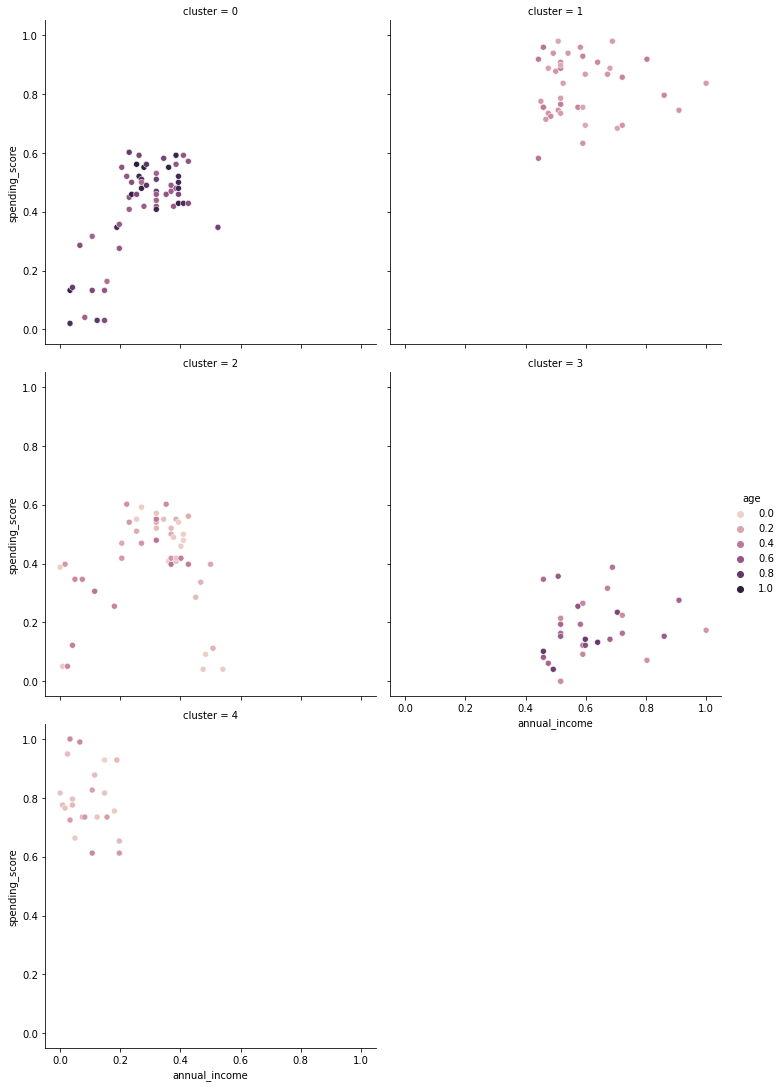

In [15]:
# plot out income vs. spending with regard to the cluster and age
sns.relplot(data=train_scaled, x="annual_income", y="spending_score", col="cluster", hue="age", col_wrap=2)

## Step 2: name the clusters in English, if they make sense!

> This is a whole entire job/career for some folks both in/out of technical/data-centric roles.

In [16]:
train_scaled.cluster = train_scaled.cluster.map({
    0: "general-older",
    1: "target",
    2: "general-younger",
    3: "frugal-high-income",
    4: "spendthrift-young",
})

train_scaled.head()

,age,annual_income,spending_score,cluster
customer_id,,,,
1,0.019231,0.000000,0.387755,general-younger
2,0.057692,0.000000,0.816327,spendthrift-young
3,0.038462,0.008197,0.051020,general-younger
4,0.096154,0.008197,0.775510,spendthrift-young
5,0.250000,0.016393,0.397959,general-younger


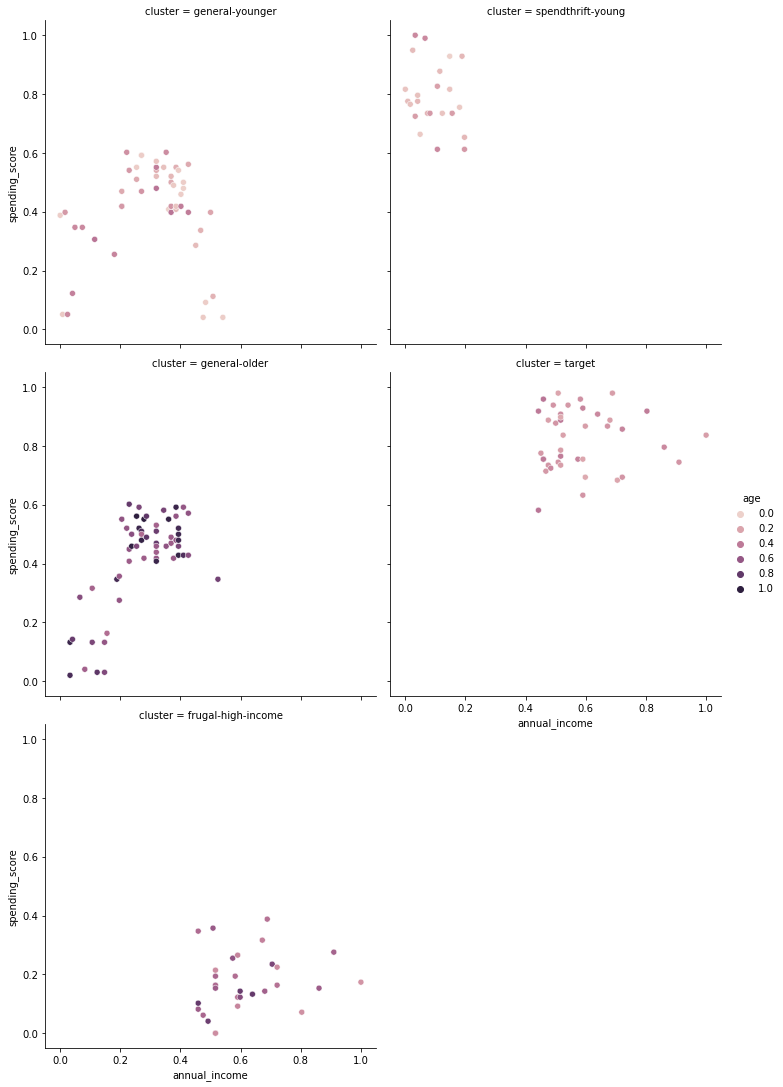

In [17]:
sns.relplot(data=train_scaled, x="annual_income", y="spending_score", col="cluster", hue="age", col_wrap=2)

In [18]:
train_scaled.groupby("cluster").mean()

,age,annual_income,spending_score
cluster,,,
frugal-high-income,0.500000,0.615847,0.172789
general-older,0.722149,0.274449,0.416080
general-younger,0.174254,0.303111,0.408580
spendthrift-young,0.144649,0.092659,0.791482
target,0.286058,0.582787,0.821684


In [19]:
train_scaled.groupby("cluster").min()

,age,annual_income,spending_score
cluster,,,
frugal-high-income,0.269231,0.459016,0.000000
general-older,0.461538,0.032787,0.020408
general-younger,0.000000,0.000000,0.040816
spendthrift-young,0.000000,0.000000,0.612245
target,0.173077,0.442623,0.581633


In [20]:
train_scaled.groupby("cluster").max()

,age,annual_income,spending_score
cluster,,,
frugal-high-income,0.788462,1.000000,0.387755
general-older,1.000000,0.524590,0.602041
general-younger,0.423077,0.540984,0.602041
spendthrift-young,0.326923,0.196721,1.000000
target,0.423077,1.000000,0.979592


## Option 1: Use the clusters to simplify multiple other variables (dimensionality reduction)
- Since the cluster names make sense, we can use them instead of age, spending, and income.
- This might be useful to reduce features (called dimensionality reduction)
- Dimensionality reduction might likely help other model performance (regressions, classifications)
- Simplifying our analysis to a handful of English terms can help with our storytelling.
- Business and stakeholders, generally, _crave_ simple answers. Clustering can help you with that.

In [21]:
train_scaled.drop(columns=["age", "annual_income", "spending_score"]).head()

,cluster
customer_id,
1,general-younger
2,spendthrift-young
3,general-younger
4,spendthrift-young
5,general-younger


## Option 2:  Use cluster names as a target variable to classify new data
- If our English label is super useful, we may want to use it as the target variable in classification
- We can take in new data and classify it!

## Option 3: Perform much deeper EDA and/or modeling for each cluster, individually

- Cluster 0 may have an upward linear trend between income and spending, that would be its own model
- Cluster 1 may have an up then down polynomial trend between income and spending, that would be its own model
- Cluster 2 may be more random, for example

Consider how each cluster can be its own population _of_ that cluster's members. 

Then use the tools we already use (visualization, hypothesis testing, modeling) to investigate similarities/differences.

- We can dive into each individual cluster individually w/ exploration
    - stats + hypothesis testing
    - visualizations for each cluster, comparing/contrasting
- We can model each cluster individually to make predictions for new customers who belong that cluster
- If we have enough customers + data (HEB//USAA/etc...) we could do even more clustering on each cluster for cluster-ception!